# Official public work with private tools

The controversy of Hilary Clinton's email hit the headlines in 2015. The goal of this project is to get a precise view of her network based on the emails publicly available on [Kaggle](https://www.kaggle.com/kaggle/hillary-clinton-emails). Unfortunately, the database is dirty as anyone could expect. Our work will be divided into the following tasks:

1. Clean the data and recover
2. Enrich the data
3. maybe go back to 1

At this point, drawing a basic graph should be possible.

4. Develop a system to cluster a document into a category
5. Show these categories in the final graph.

We remind that the goal of this milestone is as follows:

1. Handle the data in its size.

2. Understand the data (formats, distribution, missing values, correlations, etc.)

3. Consider a way to enrich, filter, transform the data according to your needs.

4. Update our plan in a reasonable way:
    
    4.1. Reflecting our improved knowledge after data acquaintance
    
    4.2. Discuss how your data suits our project needs 
    
    4.3. Discuss the methods that we will use, and provide the essential mathematical details
    
5. Show that the plan for analysis is reasonable, discussed considered choices but finally dropped


## Previously

As discussed in the first Milestone, we expected data cleaning, including text processing, handling missing values etc. as a major task of the Milestone. We considered that about 60-80% of our task (in the golbal Milestone) will be this. Without any surprise, we remark this expectation to be true. Indeed, database is dirty, really dirty... Although a lot of preprocess seemed to have been already done from the `rawText` of the `emails` database, we remark the latter to have been really poor. For example, in order to construct the Hillary's Network we need the exact `receiver` and `sender` of any emails. We remark some obvious mistakes in the Aliases correspondance with the personId for example. We explain deeper below the major difficulty that we have encountered and how we have finally handled them.

As said above, this Milestone focuses essentially on data cleaning and preprocess of rawText. Moreover, according to the questions and tasks we expect to provide, we have to clean and process data for the following features:

1. 'To' and 'From' (who receives and sends emails)

2. 'Date' (precise date of emails sending)

3. Extract content of emails (as good as possible) before preprocessing and cleaning

These three steps are crucial.

## Plan

1. Data exploration 

    1.1. how are `aliases` and `personId` related? 

    1.2. how clean are `MetaDataTo` ('To') and `MetaDataFrom` ('From')? are there missing values? 
    
    1.3. what is the behaviour of the content of `rawText`? (is it messy, multi-emails, etc)
        
2. Data Cleaning and Processing

    2.1. Clean the `aliases` and `personId` relation
    
    2.2. Construction clean `To` and `From` features by processing and NaN filling
    
    2.3. Text cleaning for `rawText` (remove inappropriate lines)
    
    2.4. Text processing (lowcase, remove stopwords, remove short sentences, stemmatization, etc)
    
    2.5. Features engineering 
           
        2.5.0. Emails time distribution

        2.5.1. Map emails to countries/regions
        
        2.5.2. Word-frequency
        
        2.5.3. Research of thematics
        
3. Pre-results

    3.1. Adjacency matrix (Hillary's network) construction
    
    .....
        
3. Milestone 3, to be done: graph visu, map visu, 


## Data exploration

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk, re, string ,collections
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from datetime import datetime, date, time
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

from extractor import Extractor
from process import Process
from analyse import Analyse
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

In [2]:
data_folder = "../data/"

The data is available in two formats: csv and sql. This means that the elements are somehow related. We will see later that the entity relationship diagram is not as it should have been done.

In [3]:
#Data extraction from the csv-files
emails_raw = pd.read_csv(data_folder + 'Emails.csv')
persons = pd.read_csv(data_folder + 'Persons.csv')
aliases = pd.read_csv(data_folder + 'Aliases.csv')
email_receivers = pd.read_csv(data_folder + 'EmailReceivers.csv')

In [4]:
print("emails:", emails_raw.shape)
print("persons:", persons.shape)
print("aliases:", aliases.shape)
print("email receivers:", email_receivers.shape)

emails: (7945, 22)
persons: (513, 2)
aliases: (850, 3)
email receivers: (9306, 3)


For the moment, let's discover what we have. Extraction was performed according to some fields. Let us check whether or not we can rely on it.

In [5]:
persons.head()

,Id,Name
0,1,111th Congress
1,2,AGNA USEMB Kabul Afghanistan
2,3,AP
3,4,ASUNCION
4,5,Alec


In [6]:
persons.dtypes

Id       int64
Name    object
dtype: object

In [7]:
aliases.head()

,Id,Alias,PersonId
0,1,111th congress,1
1,2,agna usemb kabul afghanistan,2
2,3,ap,3
3,4,asuncion,4
4,5,alec,5


In [8]:
aliases.dtypes

Id           int64
Alias       object
PersonId     int64
dtype: object

## 1.1. how are `aliases` and `personId` related?

In [9]:
aliases.sort_values(by='PersonId')

,Id,Alias,PersonId
0,1,111th congress,1
1,2,agna usemb kabul afghanistan,2
2,3,ap,3
3,4,asuncion,4
4,5,alec,5
5,6,dupuy alex,6
6,7,american beverage association,7
7,8,mayock andrew,8
9,10,shapiroa@state.gov,9
8,9,shapiro andrew j,9


In [10]:
aliases.Alias

0                     111th congress
1       agna usemb kabul afghanistan
2                                 ap
3                           asuncion
4                               alec
5                         dupuy alex
6      american beverage association
7                      mayock andrew
8                   shapiro andrew j
9                 shapiroa@state.gov
10                slaughter annmarie
11              slaughter anne marie
12               slaughter annemarie
13              slaughtera@state.gov
14                      lake anthony
15               valenzuela arturo a
16            valenzuelaaa@state.gov
17                        kimoon ban
18                      obama barack
19                         president
20           bam@mikulski.senate.gov
21                      mikulski bam
22           mikulski bam (mikulski)
23          mikulski bam (mitkulski)
24            mikulskibam (mikulski)
25                     betsy.ebeling
26                     ebeling betsy
2

In [11]:
aliases.PersonId.is_unique

False

In [12]:
aliases.Alias.is_unique

True

### Remarks and Issues

`Aliases` is not to be unique per Aliases while `persons` is. Multiple obviously same Aliases point on a single person. We have to handle this in order to have an efficient database.

Moreover we remark that `Id` from the person dataframe is supposed to be unique by name. Obviously it is not the case. Indeed, considering the `Id` 512 and 513 for instance, correspond both to the same person. There are several similar example.

We can solve this issue by creating a table which will map the false duplicated into a single person. We will create this table during the next milestone because this is a detail and we have more important stuff now. Of course, it hurts the correctness of the network but it does not prevent us to start working on it.

For the next tasks, and particularly to the creation of the Hillary's network, we first decide to associate each `MetadataTo` and `MetadataFrom` to its PersonId through Alias merge and PersonId. After that we will focus on the X persons who communicates the most with Hillary and to represent the corresponding network.

## 1.2. how clean are `MetaDataTo` ('To') and `MetaDataFrom` ('From')? are there missing values? 

### 2.1. Clean the `aliases` and `personId` relation
    
### 2.2. Construction clean `To` and `From` features by processing and NaN filling
    

As said above, we get some issues with these two features since data are really dirty. Even if the Aliases and Persons datatable are provided, we remark some lack of correspondance. Keeping this in mind for the next Milestone, we focus in this section on handling missing values for those data. Then our goal is to transpose MetadataTo to its corresponding personId.

The different steps are as follows:

1. For missing MetadataTo/SenderPersonId, find them in the rawText

2. Fetch MetadataTo to PersonId

In [13]:
emails_raw.dtypes

Id                                int64
DocNumber                        object
MetadataSubject                  object
MetadataTo                       object
MetadataFrom                     object
SenderPersonId                  float64
MetadataDateSent                 object
MetadataDateReleased             object
MetadataPdfLink                  object
MetadataCaseNumber               object
MetadataDocumentClass            object
ExtractedSubject                 object
ExtractedTo                      object
ExtractedFrom                    object
ExtractedCc                      object
ExtractedDateSent                object
ExtractedCaseNumber              object
ExtractedDocNumber               object
ExtractedDateReleased            object
ExtractedReleaseInPartOrFull     object
ExtractedBodyText                object
RawText                          object
dtype: object

Unfortunately, we will have to perform some actions to get the identities of the 'from', 'to' and 'cc'. Actually, we have the value of the 'to' from the table `emails_receiver` and it points towards the `PersonId` field. However, the fields 'from' and 'cc' point towards the `aliases` (not even its identifiers!).

In [14]:
emails_raw.MetadataCaseNumber.unique()

array(['F-2015-04841', 'F-2014-20439', 'F-2014-020439', 'F-2013-20439',
       'O-2014-20439'], dtype=object)

In [15]:
emails_raw.MetadataDocumentClass.unique()

array(['HRC_Email_296', 'HRCEmail_JuneWeb', 'HRCEmail_JulyWeb',
       'Clinton_Email_August_Release'], dtype=object)

In [16]:
emails_raw.ExtractedReleaseInPartOrFull.unique()

array(['RELEASE IN FULL', 'RELEASE IN PART', 'UNKNOWN'], dtype=object)

The meaning of these fields are obscure and we assume there are not relevant for our case.

It is time to cast what we can.

In [17]:
emails_raw.MetadataDateSent = emails_raw.MetadataDateSent.map(pd.to_datetime)
emails_raw.MetadataDateReleased = emails_raw.MetadataDateReleased.map(pd.to_datetime)
emails_raw.ExtractedDateReleased = emails_raw.ExtractedDateReleased.map(pd.to_datetime)

## Restructuring the tables

The structure of the database does not respect the basic principles of well design database (foreign key, decoupling, many elements in a single cell...). We can see it if we draw the entity relationship diagram.

    ----------        /\       -----------
    | Emails |-------<  >------| Aliases |
    ----------        \/       -----------
         |             |            |
         |             |            |
         |             |            |
         /\       -----------       /\
        <  >------| Persons |------<  >
         \/       -----------       \/

The links between the tables should not be redundant because this leads to possible inconsistent states and errors. We need to decouple what we have.

    ----------       /\        -----------       /\       -----------
    | Emails |------<  >------ | Persons |------<  >------| Aliases |
    ----------       \/        -----------       \/       -----------

### Choose relevant fields

Fortunately, `ExtractedDataSent` is redundant because it is contained in `MetadataDateSent` when it is not `null`. So we can simply drop it. This is great because it saves us from a lot of monkey work.

While testing manually random values, we conclude we will have to redo what was supposed to be done with most of the extracted values.

In [18]:
# We only keep the fields which appear in the itemization above
emails = emails_raw[['Id', 'MetadataSubject', 'SenderPersonId', 'MetadataTo', 'MetadataDateSent', 'MetadataDateReleased', 'RawText']]

emails.head()

,Id,MetadataSubject,SenderPersonId,MetadataTo,MetadataDateSent,MetadataDateReleased,RawText
0,1,WOW,87.0,H,2012-09-12 04:00:00,2015-05-22 04:00:00,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,NaN,H,2011-03-03 05:00:00,2015-05-22 04:00:00,UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,CHRIS STEVENS,32.0,;H,2012-09-12 04:00:00,2015-05-22 04:00:00,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,CAIRO CONDEMNATION - FINAL,32.0,H,2012-09-12 04:00:00,2015-05-22 04:00:00,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,80.0,"Abedin, Huma",2011-03-11 05:00:00,2015-05-22 04:00:00,B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


## find missing SenderPersonId and fetch with PersonId

In [19]:
# SenderPersonId
def fetch_from_alias(alias_raw, content_raw):
    if alias_raw is not None:
        alias_found = Process.alias(alias_raw)
        person_id = aliases[aliases.Alias.str.strip() == alias_found].PersonId.values
        if len(person_id) == 1:
            return person_id[0]
    return np.nan

def fetch_from_pid(personId, content_raw):
    if not np.isnan(personId):
        return personId
    alias_extracted = Extractor.sender_alias(content_raw)
    return fetch_from_alias(alias_extracted, content_raw)

emails['from'] = emails.apply(lambda row: fetch_from_pid(row['SenderPersonId'], row['RawText']), axis=1)
nb_nan = emails.SenderPersonId.isna().sum()
nb_from_recover = nb_nan - emails['from'].isna().sum()

emails.drop('SenderPersonId', axis=1, inplace=True)

print("We manage to recover %d out of %d NaN for the sender_id." % (nb_from_recover, nb_nan))

We manage to recover 11 out of 157 NaN for the sender_id.


### How many NaN can we manage ?

In [20]:
# MetadataTo
counter_not_nan = 0
counter_recover = 0
emails['to'] = np.nan

for i in range(emails.shape[0]):
    if not isinstance(emails.MetadataTo[i], str):
        continue
    counter_not_nan += 1
    alias = Process.alias(str(emails.MetadataTo[i]))
    person_id = aliases[aliases.Alias.str.strip() == alias].PersonId.values
    if len(person_id) == 1:
        emails.iat[i, -1] = person_id[0]
        counter_recover += 1
    else:
        print(emails.MetadataTo[i]) # could not match a person

emails.drop('MetadataTo', axis=1, inplace=True)
print('***')
print("We manage to compute %d out of %d for the receiver_id." % (counter_recover, counter_not_nan))

michele.flournoy
Axelrod_D
Terry.Duffy
glantz.
rosemarie.howe ;H
cheryl.mills ;H
rrh.interiors
mh.interiors
H;preines
H;preines
Abedin, Huma; H
Abedin, Huma; H
Ki-moon, Ban
Sullivan, Jake; H
Etats-Unis D'Amerique
Etat-Unis D'Amerique
Duk-soo, Han
Duk-soo, Han
Betsy.Ebeling
***
We manage to compute 7671 out of 7690 for the receiver_id.


The `MetadataTo` field contains many `NaN`s and some elements (list above) could match a person. Hope is not lost because we can extract this value from the `RawText` field.

## Proceed similarly for MetadataTo

In [21]:
def fetch_alias(to, content_raw):
    if not np.isnan(to):
        return to
    else:
        alias_extracted = Extractor.destination_alias(content_raw)
        return fetch_from_alias(alias_extracted, content_raw)

emails['to'] = emails.apply(lambda row: fetch_alias(row['to'], row['RawText']), axis=1)
nb_nan = emails.to.isna().sum()
nb_from_recover = nb_nan - emails.to.isna().sum()

print("We manage to recover %d out of %d NaN for the receiver." % (nb_from_recover, nb_nan))

We manage to recover 0 out of 244 NaN for the receiver.


It looks like the one who preprocessed the database before us followed the same procedure.

There is one more thing we can do: we use the table `email_receivers`. As said earlier, it does not make any difference between the one who received the email directly or the one who received it through the 'cc' option.

Our first guess is that the first row containing a given email is always the receiver and the others, if any, are the cc. Let's check it this assumption holds.

In [22]:
nb_tot = 0
nb_correct = 0
for i in range(emails.shape[0]):
    if not np.isnan(emails.to[i]):
        pids = email_receivers[email_receivers.EmailId == emails.Id[i]].PersonId.values
        if len(pids) > 1:
            nb_tot += 1
            if pids[0] == emails.to[i]:
                nb_correct += 1

print("%d / %d." % (nb_correct, nb_tot))

795 / 1244.


There are 1244 emails for which we have the destination AND for which there are at least 2 rows in `email_receivers`. Among these 1244, the first row is the destination in 795 times. This number is not huge but it is not small either. Assuming this ratio always holds, it is better to adopt this strategy than choosing randomly.

## Find receiver as Cc

In [23]:
def fetch_pid_through_email_receiver(eid, previous_to):
    if np.isnan(previous_to):
        pids = email_receivers[email_receivers.EmailId == eid].PersonId.values
        if len(pids) >= 1:
            return pids[0]
    return previous_to

nb_nan_before = emails.to.isna().sum()
emails['to'] = emails.apply(lambda row: fetch_pid_through_email_receiver(row['Id'], row['to']), axis=1)
nb_nan_after = emails.to.isna().sum()
recover = nb_nan_before - nb_nan_after
print("%d out of %d NaN." % (recover, nb_nan_before))

15 out of 244 NaN.


Using the stategy we have described earlier, we feed 15 more rows with a value for the field `to`.

Now that we are done with the 'from' and 'to', we can work on the 'cc'. We use the table `email_receivers` and drop the row whose `EmailId` and `PersonId` combination appears in the table `emails`.

In [24]:
table_cc = pd.merge(emails, email_receivers, left_on='Id', right_on='EmailId')
table_cc = table_cc[table_cc.to != table_cc.PersonId][['EmailId', 'PersonId']]

In [25]:
print(len(table_cc))
print(len(email_receivers))

1539
9306


As one would expect, we get a subset of the intial set.

Finally, we have our new structure. But it's only a beginning.

## 1.3. what is the behaviour of the content of `rawText` ? (is it messy, multi-emails, etc)
    
We remark that the rawText are not clean at all. It is quite difficult to catch the real content of the email, to now if a supposed email is one or an exchange of emails, etc. 

Assuming there is a pattern. It is not easy to find it. That's why we will use some basic rules we describe later.

To ease the tasks of the Milestone we first assume that one rawText is one exchange, but that all the content is used at the same time in the analysis (we do not split exchange of emails, email per email). Secondly, we need to process the data to get the core of the content. We proceed as follows:

## Text pre-processing

It is time to clean the (raw) content. Since the database we have contains less than 10,000 emails, we need to preprocess the data in an effective way. We need to remove common words and common sentences which appear almost on each email. This is necessary when running marchine learning algorithm on it to get better results.

This could have been enough but the database is really poor. So we need to perform more actions... We will limit ourselves to:

1. Remove lines which start by a frequent sequences (e.g. "Case No...", "U.S. Department of State", ...)
2. Replace upper case by lower case
3. Remove the emails
4. Tokenization based on sentence (".", "!", "?", ...)
5. Remove punctionations and numbers.
6. Remove stop words (the one provided  by nltk)
7. [Stemming and Lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) (reducing words, "car" and "cars" should not be considered as different entity for example)
8. Ignore sentence if it contains less than 4 words. We may loose some useful information but it filters out a huge amount of dirty words which resist the previous steps.
9. Join the sentence to build the new content.

Ideally, we would like to use lemmatization. But this would be a project in the project and it would take too much time to complete and stemming produces reasonable output.

We will see that it is still not enough!

10. Remove stop word we compute based on tf-idf from the step

In [26]:
# You can test the function here
lemmatize = True
sentences = "I like flowers. This was useless, I write completely stupid stuff because I suck for these exercises"
print(Process.content(sentences, not lemmatize))
print("***")
print(Process.content(sentences, lemmatize))

useless write complet stupid stuff suck exercis
***
useless write completely stupid stuff suck exercise


In [27]:
# This may take a while...
emails['content'] = emails.RawText.map(lambda txt: Process.content(txt, False))

In [28]:
# testing results manually
idx = 200
print(emails.content[idx])
print('***')
print(emails.RawText[idx])

h latest intel libyan conflict leader militia|thank alway happi new year|sourc sourc direct access libyan nation transit council well|highest level european govern western intellig secur servic|last week decemb first week libya prime minist|abdurrahim el keib presid mustafa abdul jalil engag seri emerg plan|meet attempt deal specif issu threaten stabil new nation|transit council ntc govern|accord extrem sensit sourc speak strict|confid paramount among issu question disarm reward region|militia bore major fight regim muammar al qaddafi well|relat issu find minist senior administr new govern|individu note four occas begin|decemb group angri militiamen came el keib offic demand better|treatment clear messag support role islam law remov former qaddafi|sourc comment opinion sensit sourc el keib genuin concern|situat could spiral control threaten regim|unrest stir general abdel hakim alamin belhaj conserv islamist|stay new govern belhaj establish posit|critic action appoint without concern c

In [29]:
# now we can drop the raw content
emails = emails.drop('RawText', axis=1)

### 2.5. Features engineering and data comprehension
    
        2.5.0. Map emails to countries/regions
    
        2.5.1. Emails time distribution
                
        2.5.2. Word-frequency
        
        2.5.3. Research of thematics
        
The goal of this part is to provide a first step in features engineering. According to our needs for the Milestone tasks, we will first present an algorithm that permit to map as good as possible emails with countries, regions, persons, etc. Secondly we provide some basic tools in order to get a better understand about the subjects discussed, time distribution, etc. Finally we provide some ideas in order to find some reccurent thematics.


## Data Augmented

We would like to classify the email into (not excluding) categories like Middle East, Europe... But we do not have this information. We need to create it somehow. In order to build the data, we will use a system based on keywords.

In [30]:
emails['africa'] = emails.content.map(lambda content: Extractor.earth_area(content, "africa"))
emails['central_asia'] = emails.content.map(lambda content: Extractor.earth_area(content, "central_asia"))
emails['europe'] = emails.content.map(lambda content: Extractor.earth_area(content, "europe"))
emails['far_east'] = emails.content.map(lambda content: Extractor.earth_area(content, "far_east"))
emails['middle_east'] = emails.content.map(lambda content: Extractor.earth_area(content, "middle_east"))
emails['latino'] = emails.content.map(lambda content: Extractor.earth_area(content, "latino"))
emails['north_america'] = emails.content.map(lambda content: Extractor.earth_area(content, "north_america"))
emails['russia'] = emails.content.map(lambda content: Extractor.earth_area(content, "russia"))

In [31]:
emails.head()

,Id,MetadataSubject,MetadataDateSent,MetadataDateReleased,from,to,content,africa,central_asia,europe,far_east,middle_east,latino,north_america,russia
0,1,WOW,2012-09-12 04:00:00,2015-05-22 04:00:00,87.0,80.0,wonder strong move statement boss|pleas tell m...,False,False,False,False,False,False,False,False
1,2,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,2011-03-03 05:00:00,2015-05-22 04:00:00,194.0,80.0,h latest syria aid qaddafi sid|hrc memo syria ...,True,False,True,False,True,False,False,True
2,3,CHRIS STEVENS,2012-09-12 04:00:00,2015-05-22 04:00:00,32.0,80.0,former colleagu terribl sorri|fsos stand front...,False,False,False,False,False,False,False,False
3,4,CAIRO CONDEMNATION - FINAL,2012-09-12 04:00:00,2015-05-22 04:00:00,32.0,80.0,schwartz larri ranz david j siever marc linfie...,True,False,False,False,False,False,False,False
4,5,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,2011-03-11 05:00:00,2015-05-22 04:00:00,80.0,81.0,fw h latest syria aid qaddafi sid|hrc memo syr...,True,False,True,False,True,False,False,True


## Content is still messy

We need to remove a lot of words. And we cannot do it manually. A good idea is to use tf-idf to remove common words among documents.

In [32]:
vectorizer = TfidfVectorizer()
corpus = []
for doc in emails.content:
    corpus.append(str(doc).replace("|", " "))
vectorizer.fit_transform(corpus)
idf = vectorizer._tfidf.idf_
word_score = dict(zip(vectorizer.get_feature_names(), idf))

In [33]:
for key in word_score.keys():
    if key.startswith("afg"):
        print(key)

afg
afganistan
afgh
afgha
afghaiistai
afghalistan
afghan
afghani
afghanisan
afghanist
afghanistan
afghansn
afghanstan
afghariistan
afghathtml
afgna


This is not surprising that there are many spell mistakes. Of course, we are not able to correct everything.

In [34]:
def stop_word_based_on_emails(threshold=3.4):
    d = set()
    for (key, value) in word_score.items():
        if value < threshold:
            d.add(key)
    return d

stop_word = stop_word_based_on_emails()

# we add manually entries
stop_word.add('u')

print(stop_word)

{'unit', 'sent', 'foreign', 'like', 'countri', 'u', 'told', 'also', 'call', 'polit', 'report', 'could', 'discuss', 'time', 'today', 'includ', 'year', 'first', 'right', 'come', 'way', 'depart', 'want', 'leader', 'us', 'issu', 'tomorrow', 'made', 'nation', 'back', 'intern', 'effort', 'think', 'last', 'week', 'tri', 'get', 'american', 'may', 'two', 'secur', 'offic', 'world', 'talk', 'work', 'say', 'one', 'day', 'hous', 'presid', 'unclassifi', 'follow', 'still', 'support', 'pm', 'need', 'secretari', 'group', 'point', 'peopl', 'mani', 'much', 'case', 'sinc', 'note', 'new', 'state', 'meet', 'offici', 'let', 'use', 'said', 'see', 'move', 'end', 'give', 'public', 'continu', 'ask', 'help', 'plan', 'make', 'long', 'take', 'know', 'look', 'pleas', 'person', 'well', 'next', 'would', 'even', 'go', 'minist', 'clinton', 'polici', 'govern', 'good', 'hope'}


We remove these words from the content because they appear frequently.

In [35]:
def content_without_stop_word(content):
    ret = []
    for sentence in str(content).split('|'):
        acc = []
        for word in sentence.split():
            if word not in stop_word:
                acc.append(word)
        if len(acc) >= 1:
            ret.append(" ".join(acc))
    return "|".join(ret)

emails.content = emails.content.map(content_without_stop_word)

In [36]:
emails.content[166]

'libyan march islamist militia benghazi|peter graff suleiman al khalidi|benghazi libya fri sep prn edt|reuter thousand libyan march benghazi friday democraci|islamist militia washington blame attack consul kill four|rescu benghazi demonstr disband arm refus|weapon nato revolut toppl muammar gaddafi|marcher head main squar smaller counter demonstr hundr|hardlin islamist ansar al sharia wait|join armi forc|individu medic student ahm sanallah|late afternoon demonstr cheer atmospher famili march small children|fighter jet helicopt roar overhead show demonstr|enthusiast promot citi author|militari battalion impos ideolog libya confront saleh|gaouda member rule congress|citi stabil particip build|sign cheer atmospher ear giant cardboard model benghazi landmark lighthous|strap roof sun set crowd began dispers someon shot firework air|although main demand marcher mention attack consul seem|provid strong impetus author ralli behind weak|ambassador christoph steven libya anger anti|islam film co

## Save our transformed data

In [37]:
PATH_TO_GENERATED = '../generated/'

In [38]:
# Saving
emails.to_csv(PATH_TO_GENERATED + 'emails.csv', encoding='utf-8', index=False)
table_cc.to_csv(PATH_TO_GENERATED + 'table_cc.csv', encoding='utf-8', index=False)
persons.to_csv(PATH_TO_GENERATED + 'persons.csv', encoding='utf-8', index=False)
aliases.to_csv(PATH_TO_GENERATED + 'aliases.csv', encoding='utf-8', index=False)

In [39]:
# Fetching
emails = pd.read_csv(PATH_TO_GENERATED + 'emails.csv')
persons = pd.read_csv(PATH_TO_GENERATED + 'persons.csv')
aliases = pd.read_csv(PATH_TO_GENERATED + 'aliases.csv')
emails.MetadataDateSent = emails.MetadataDateSent.map(pd.to_datetime)
emails.MetadataDateReleased = emails.MetadataDateReleased.map(pd.to_datetime)

## Word 2 vector

Now that the content is cleaned, we need to represent it a vectorized way. We can use the word2vec alogorithm on the emails to "see" the proximity of some words.

We will not reinvent the wheel. So we use the package `gensim` and compute the vectors based on sentences (and not documents).


We train our model with the following parameters: dimension: 20, window: 4, min_count: 2. The `dimension` is the dimension of vectors. The window is a sliding rectangle containing 4 words. The `min_count` is the minimum number of times the word needs to be in the corpus to be taken into account. Finally we set `epochs` to 300.

Please, run the following command if you want to play with your input.

    > python3 main.py set_word2vec

In [40]:
model = Word2Vec.load('model_word2vec.bin')

FileNotFoundError: [Errno 2] No such file or directory: 'model_word2vec.bin'

In [ ]:
model.wv.most_similar(positive="terror", topn=10)

Word2Vec is effective when we have a corpus like wikipedia. This means we cannot really use it here since we have a small number of documents... Therefore we need to use something else.

# Visualization

It is time to see what we have. We will discover the data by

1. Observing the **dates** and making assumptions we hope to verify.
2. Clustering documents by region using an unsupervised algorithm to determine the "number of topics".
3. Creating a word cloud for each region.

## Visualization of the dates

In [41]:
from datetime import datetime

In [42]:
emails_occurrences = emails.MetadataDateSent.dropna() \
    .map(lambda dt: date(dt.year, dt.month, dt.day)) \
    .value_counts() \
    .sort_index()

In [43]:
nb_nan = emails.shape[0] - emails.MetadataDateSent.dropna().shape[0]
print("There are %d emails which are not taken into account" % (nb_nan))

There are 132 emails which are not taken into account


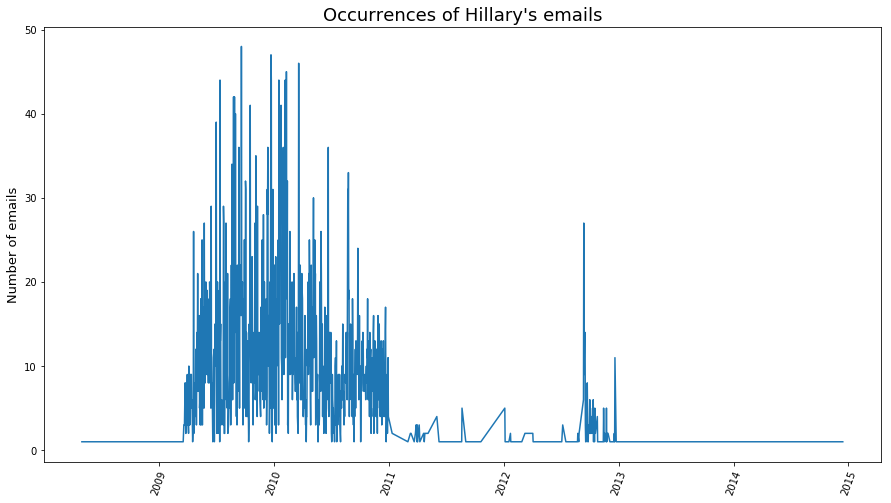

In [44]:
def plot_emails_frequencies(freq):
    plt.figure(figsize=(15,8))
    plt.plot(freq)
    plt.xticks(rotation=70)
    plt.title("Occurrences of Hillary's emails", size=18)
    plt.ylabel("Number of emails", size=13)
    plt.show()

plot_emails_frequencies(emails_occurrences)

We see three interesting moments:

* from 2009 to 2011
* from 2011 to 2012 June (it looks like some emails have not been or could not be disclosed)
* from 2012 June to 2013

We introduce some external knowledge:

    2009.03.17: France joins (again) NATO.
    2009.04   : Swine flu
    2010.04.10: Polish president dies in plane crash in Russia
    2010.04.20: BP oil split
    2010.05.10: The Greek crisis
    2010.05.11: David Cameron becomes prime minister
    2010.05.31: Gaza flotilla raid
    2011.01.01: Dilma Roussef becomes president of Brazil
    2011.01.14: Ben Ali leaves Tunisia to Saudi Arabia
    2011.01.25: Revolution starts in Egypt
    2011.02.11: Hosni Moubarak resigns
    2011.02.17: Mouammar Kadhafi's problems start
    2011.03.11: Fukishima catastroph
    2011.02.15: It starts in Syria
    2011.07.22: Anders Behring Breivik in Norway
    2011.08   : Southern Israel cross-border attacks
    2011.10.20: Mouammar Kadhafi is killed

    2012.04   : Election in France
    2012.09.11: Christopher Stevens, US ambassador in Libya is killed
    2012.11.06: Barack Obama is elected

    2013.03.15: Hugo Chavez is dead

## What words say

It is time to show what words reveal.

In [45]:
emails_africa = emails[emails['africa']]
emails_central_asia = emails[emails['central_asia']]
emails_europe = emails[emails['europe']]
emails_far_east = emails[emails['far_east']]
emails_middle_east = emails[emails['middle_east']]
emails_latino = emails[emails['latino']]
emails_north_america = emails[emails['north_america']]
emails_russia = emails[emails['russia']]

In [46]:
def plot_distribution_email(start=None, end=None):
    labels = ('Africa', 'Central Asia', 'Europe', 'Far East', 'Middle East', 'North Amercia', 'Latino', 'Russia')
    y_pos = np.arange(len(labels))
    if start is None or end is None:
        title = 'Distribution of the emails'
        mail_count = [emails_africa.shape[0], emails_central_asia.shape[0], emails_europe.shape[0],
                      emails_far_east.shape[0], emails_middle_east.shape[0], emails_north_america.shape[0],
                      emails_latino.shape[0], emails_russia.shape[0]]
    else:
        title = 'Distribution of the emails from %d-%d-%d to %d-%d-%d' % (start[0], start[1], start[2], end[0], end[1], end[2])
        
        tmp_africa = emails_africa.dropna(subset=['MetadataDateSent'])
        tmp_africa = tmp_africa[(tmp_africa.MetadataDateSent >= datetime(start[0], start[1], start[2])) &\
                               (tmp_africa.MetadataDateSent <= datetime(end[0], end[1], end[2]))].shape[0]
        tmp_central_asia = emails_central_asia.dropna(subset=['MetadataDateSent'])
        tmp_central_asia = tmp_central_asia[(tmp_central_asia.MetadataDateSent >= datetime(start[0], start[1], start[2])) &\
                               (tmp_central_asia.MetadataDateSent <= datetime(end[0], end[1], end[2]))].shape[0]
        tmp_europe = emails_europe.dropna(subset=['MetadataDateSent'])
        tmp_europe = tmp_europe[(tmp_europe.MetadataDateSent >= datetime(start[0], start[1], start[2])) &\
                               (tmp_europe.MetadataDateSent <= datetime(end[0], end[1], end[2]))].shape[0]
        tmp_far_east = emails_far_east.dropna(subset=['MetadataDateSent'])
        tmp_far_east = tmp_far_east[(tmp_far_east.MetadataDateSent >= datetime(start[0], start[1], start[2])) &\
                               (tmp_far_east.MetadataDateSent <= datetime(end[0], end[1], end[2]))].shape[0]
        tmp_middle_east = emails_middle_east.dropna(subset=['MetadataDateSent'])
        tmp_middle_east = tmp_middle_east[(tmp_middle_east.MetadataDateSent >= datetime(start[0], start[1], start[2])) &\
                               (tmp_middle_east.MetadataDateSent <= datetime(end[0], end[1], end[2]))].shape[0]
        tmp_north_america = emails_north_america.dropna(subset=['MetadataDateSent'])
        tmp_north_america = tmp_north_america[(tmp_north_america.MetadataDateSent >= datetime(start[0], start[1], start[2])) &\
                               (tmp_north_america.MetadataDateSent <= datetime(end[0], end[1], end[2]))].shape[0]
        tmp_latino = emails_latino.dropna(subset=['MetadataDateSent'])
        tmp_latino = tmp_latino[(tmp_latino.MetadataDateSent >= datetime(start[0], start[1], start[2])) &\
                               (tmp_latino.MetadataDateSent <= datetime(end[0], end[1], end[2]))].shape[0]
        tmp_russia = emails_russia.dropna(subset=['MetadataDateSent'])
        tmp_russia = tmp_russia[(tmp_russia.MetadataDateSent >= datetime(start[0], start[1], start[2])) &\
                               (tmp_russia.MetadataDateSent <= datetime(end[0], end[1], end[2]))].shape[0]
        
        mail_count = [tmp_africa, tmp_central_asia, tmp_europe,
                      tmp_far_east, tmp_middle_east, tmp_north_america,
                      tmp_latino, tmp_russia]
    plt.figure(figsize=(15,3))
    plt.barh(y_pos, mail_count, align='center', alpha=1)
    plt.yticks(y_pos, labels)
    plt.xlabel('Number of emails')
    plt.title(title)

    plt.show()

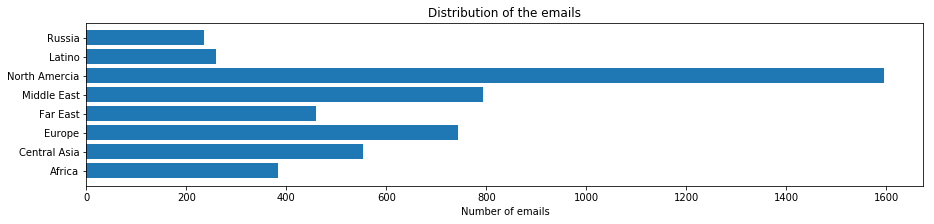

In [47]:
plot_distribution_email()

Some care is necessary before interpreting this plot. It is not a surprse that North America outnumbered the other places. Since the content of the emails are based from the american point of view, keyword extraction will consider more emails related to North America than we should.

In [48]:
def most_common_word(contents, n=30):
    '''Extraction the most common words from each region'''
    contents_as_str = contents.str.cat(sep=' ')
    contents_as_str = contents_as_str.replace('|', ' ')
    word_freq_dist = nltk.FreqDist(contents_as_str.split())
    most_common = word_freq_dist.most_common(n)
    return most_common

In [49]:
def word_bar_plot(words, title):
    '''Plot the horizontal bar chart for each region'''
    plt.figure(figsize=(15,7))
    plt.barh(range(len(words)),[val[1] for val in words], align='center')
    plt.yticks(range(len(words)), [val[0] for val in words])
    plt.xlabel('Words count')
    plt.title(title)
    plt.show()

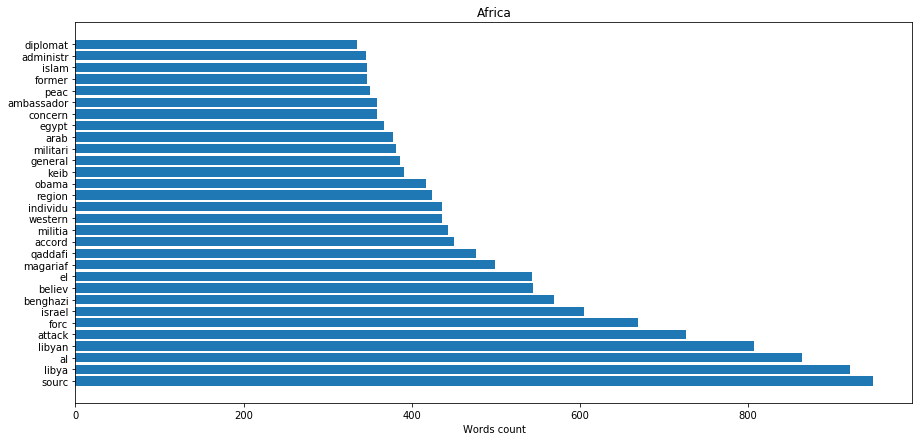

In [50]:
word_bar_plot(most_common_word(emails_africa.content), 'Africa')

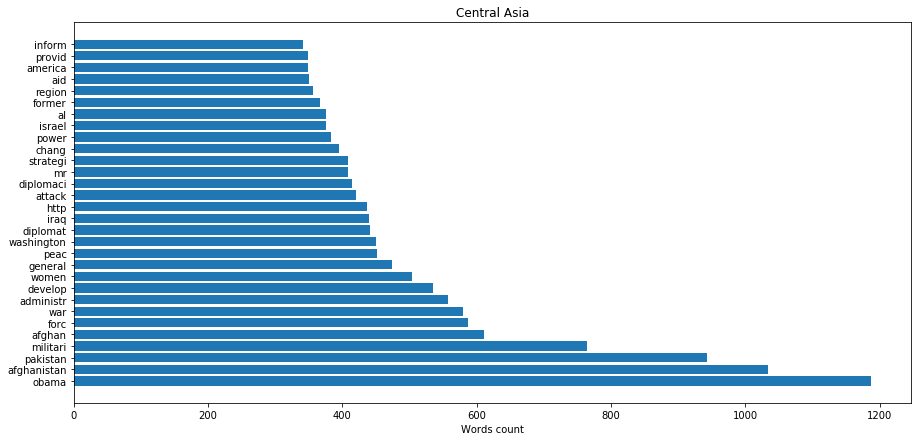

In [51]:
word_bar_plot(most_common_word(emails_central_asia.content), 'Central Asia')

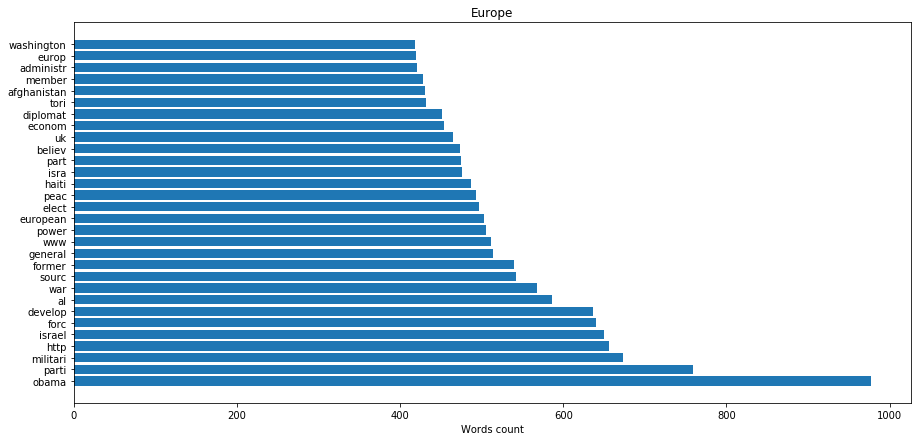

In [52]:
word_bar_plot(most_common_word(emails_europe.content), 'Europe')

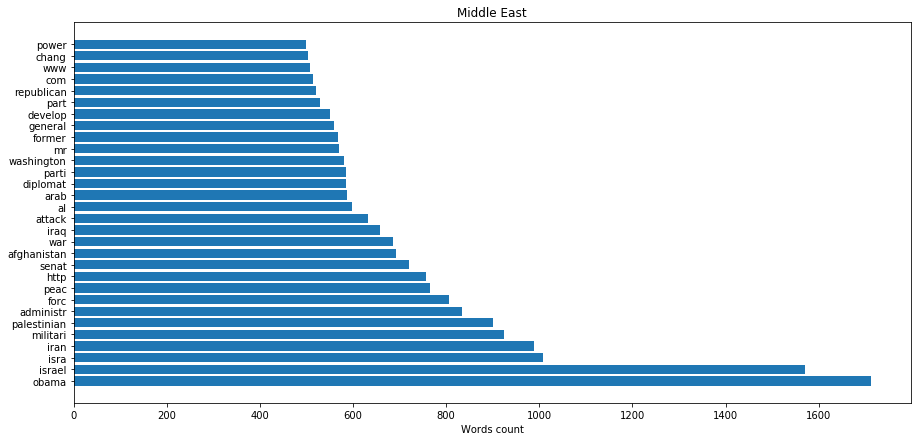

In [53]:
word_bar_plot(most_common_word(emails_middle_east.content), 'Middle East')

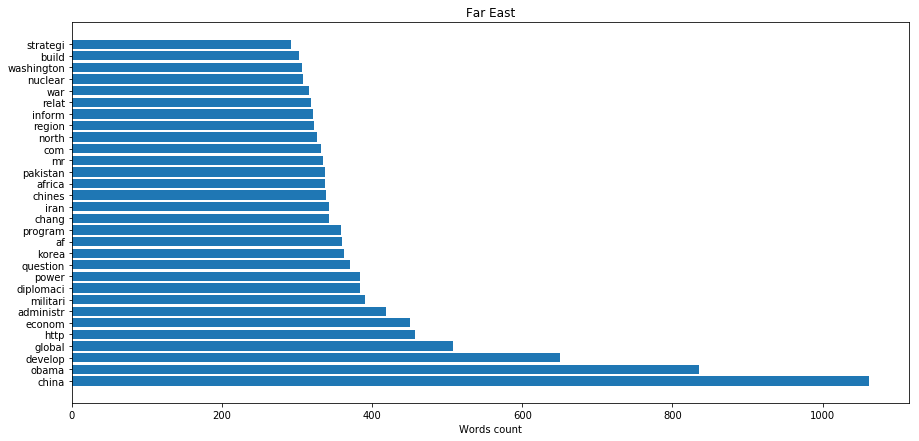

In [54]:
word_bar_plot(most_common_word(emails_far_east.content), 'Far East')

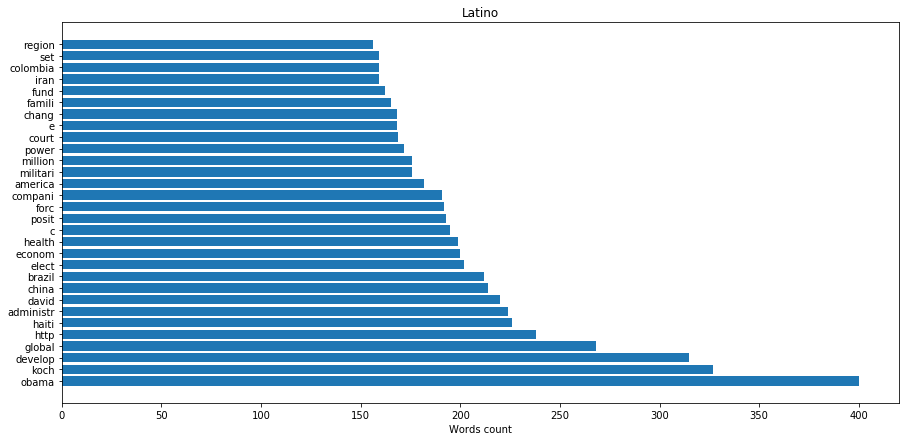

In [55]:
word_bar_plot(most_common_word(emails_latino.content), 'Latino')

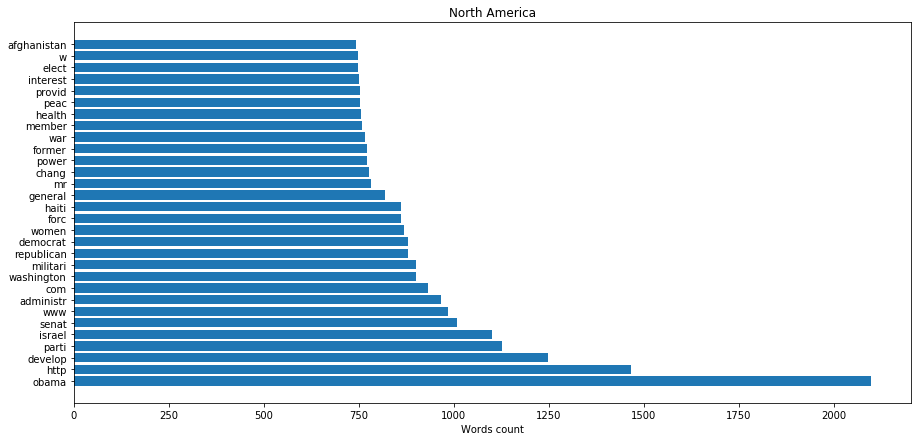

In [56]:
word_bar_plot(most_common_word(emails_north_america.content), 'North America')

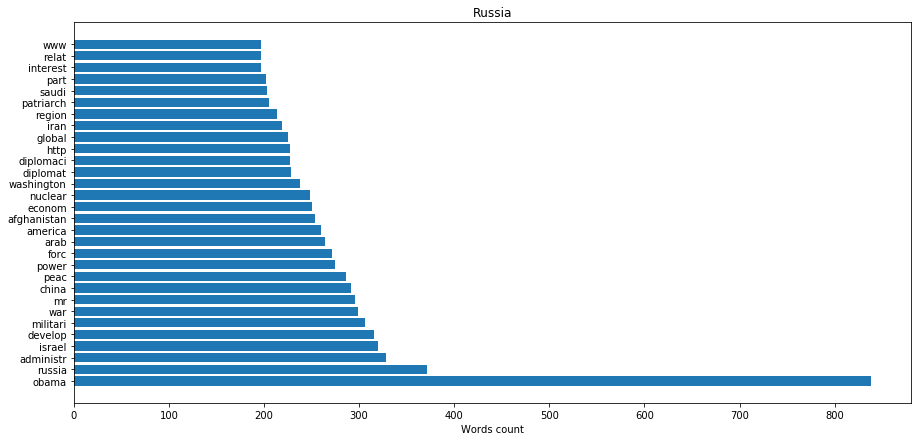

In [57]:
word_bar_plot(most_common_word(emails_russia.content), 'Russia')

Before drawing conclusions, we should keep in mind that the dataset is small, and some emails contain a compilation of what is happening in the world. Therefore, the fact that some words appear other words does mean necessarily there are related as we could think.

**Suprises:**

* Israel appears in North America, Middle East, Central Asia, Russia, Europe, Africa.
* Ukraine does not appear.
* Iran appears in Latino world... but not Venezuela.
* Women appear in the top 30 but not terrorist nor taliban in Central Asia. We see a big contrast with the official speeches which are claiming to 'fight terror'.

Based on the horizontal plot for each region, we guess the main subjects are:

* **Africa:** Libyan war. Revolution of 2011.
* **Central Asia:** Afghanistan. Pakistan. Stability.
* **Europe:** Afghanistant, Israel. It is hard to explain that. The most likely reason is that content related to Europe appears in compilation with other parts of the world.
* **Far East:** North Korea, Nuclear. China.
* **Middle east:** Israel-Palestin war. Iran. Iraq
* **North America:** There is nothing we can say because US cannot not be connected to everything because all the news is described from their point of view (as said earlier).
* **Latino:** Contains only around 250 emails for subjects completely different. This means we cannot conclude anything.
* **Russia:** The fact that Saudi, Iran, Afghanistan, Arab, China, Israel suggests Russia only appears in compilation of what hapens in the world.

In the end, it looks like we can only look at Africa, Central Asia, Middle East.

### Evolution of the distribution

We have seen that there are three moments which can be identified when looking at the plot of the number of emails per day. Let's have a look at:

(Note the scale are different)

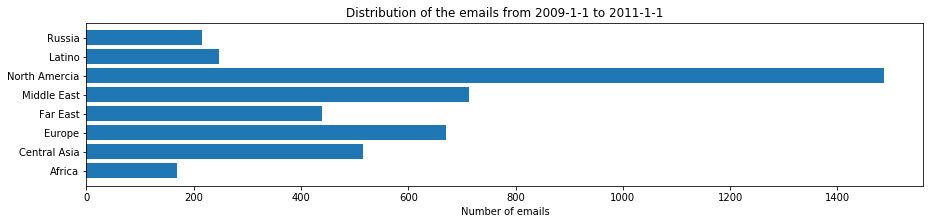

In [58]:
plot_distribution_email([2009, 1, 1], [2011, 1, 1])

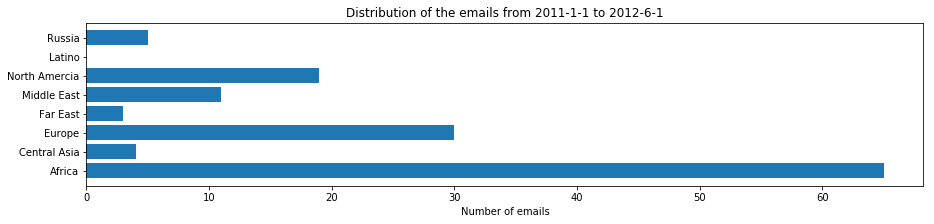

In [59]:
plot_distribution_email([2011, 1, 1], [2012, 6, 1])

The above plot covers the Arab revolution in 2011 + NATO operation in Libya.

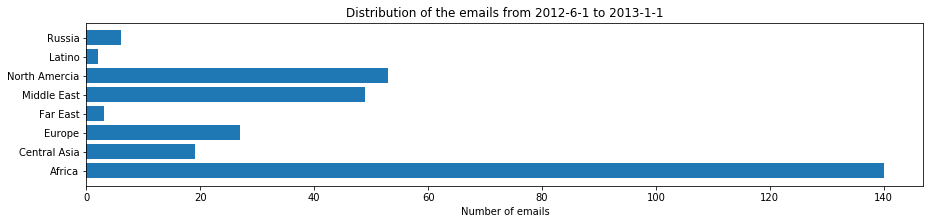

In [60]:
plot_distribution_email([2012, 6, 1], [2013, 1, 1])

As we have said, the US ambassador for Libya was killed in September 2012. This is probably the reason why we have so many emails one year after Kaddafi.

## Visualization of the classes

If we compare the dataset we have with what we are used to have, then we can say our dataset is really small. However, it is still impossible for a human to read and group documents together. It is obvious we need an unsupervised algorithm. We hope the cosine distance between document will reveal the number of classes per region and complete with external knowledge to name them.

The dendogram code is taken from [here](http://brandonrose.org/clustering) on November 24th 2018.

In [61]:
# Dendogram
def plot_dendogram(region):
    emails_filtered = emails[emails.content.map(lambda content: Extractor.earth_area(str(content), region))].content
    tfidf_matrix = Analyse.tfidf_matrix(emails_filtered)
    dist = 1 - cosine_similarity(tfidf_matrix)
    linkage_matrix = ward(dist)
    
    fig, ax = plt.subplots(figsize=(15, 20)) # set size
    ax = dendrogram(linkage_matrix, orientation="right")

    plt.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)

    plt.tight_layout() #show plot with tight layout

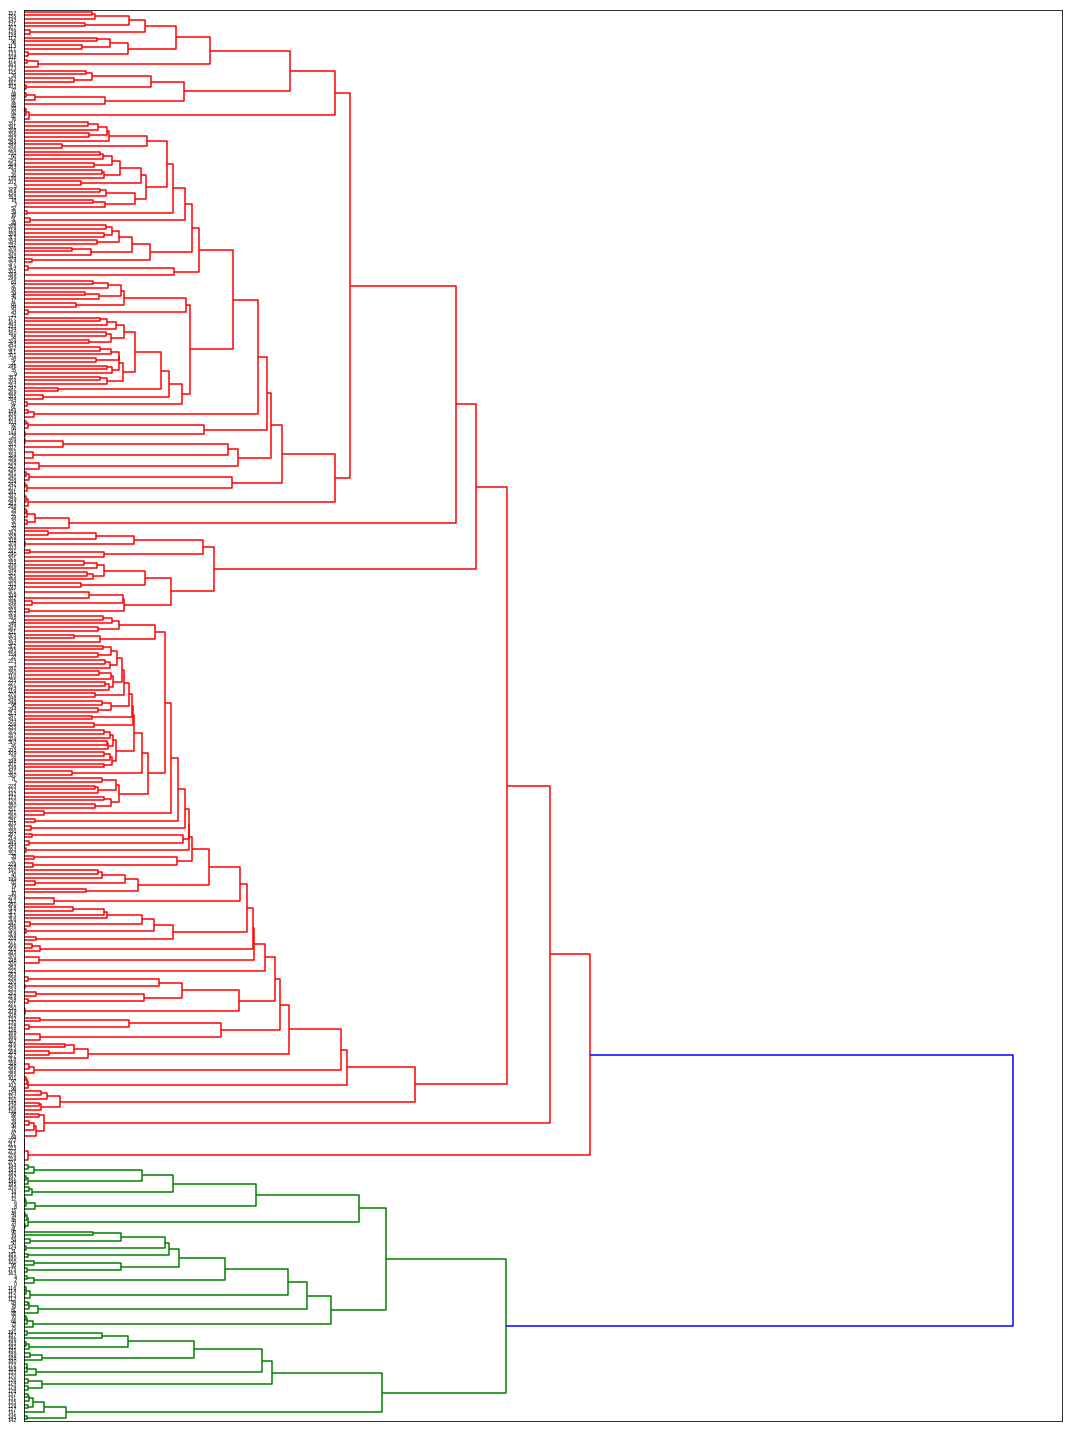

In [62]:
plot_dendogram('africa')

Africa is dominated by 3 classes even if we only see two colors.

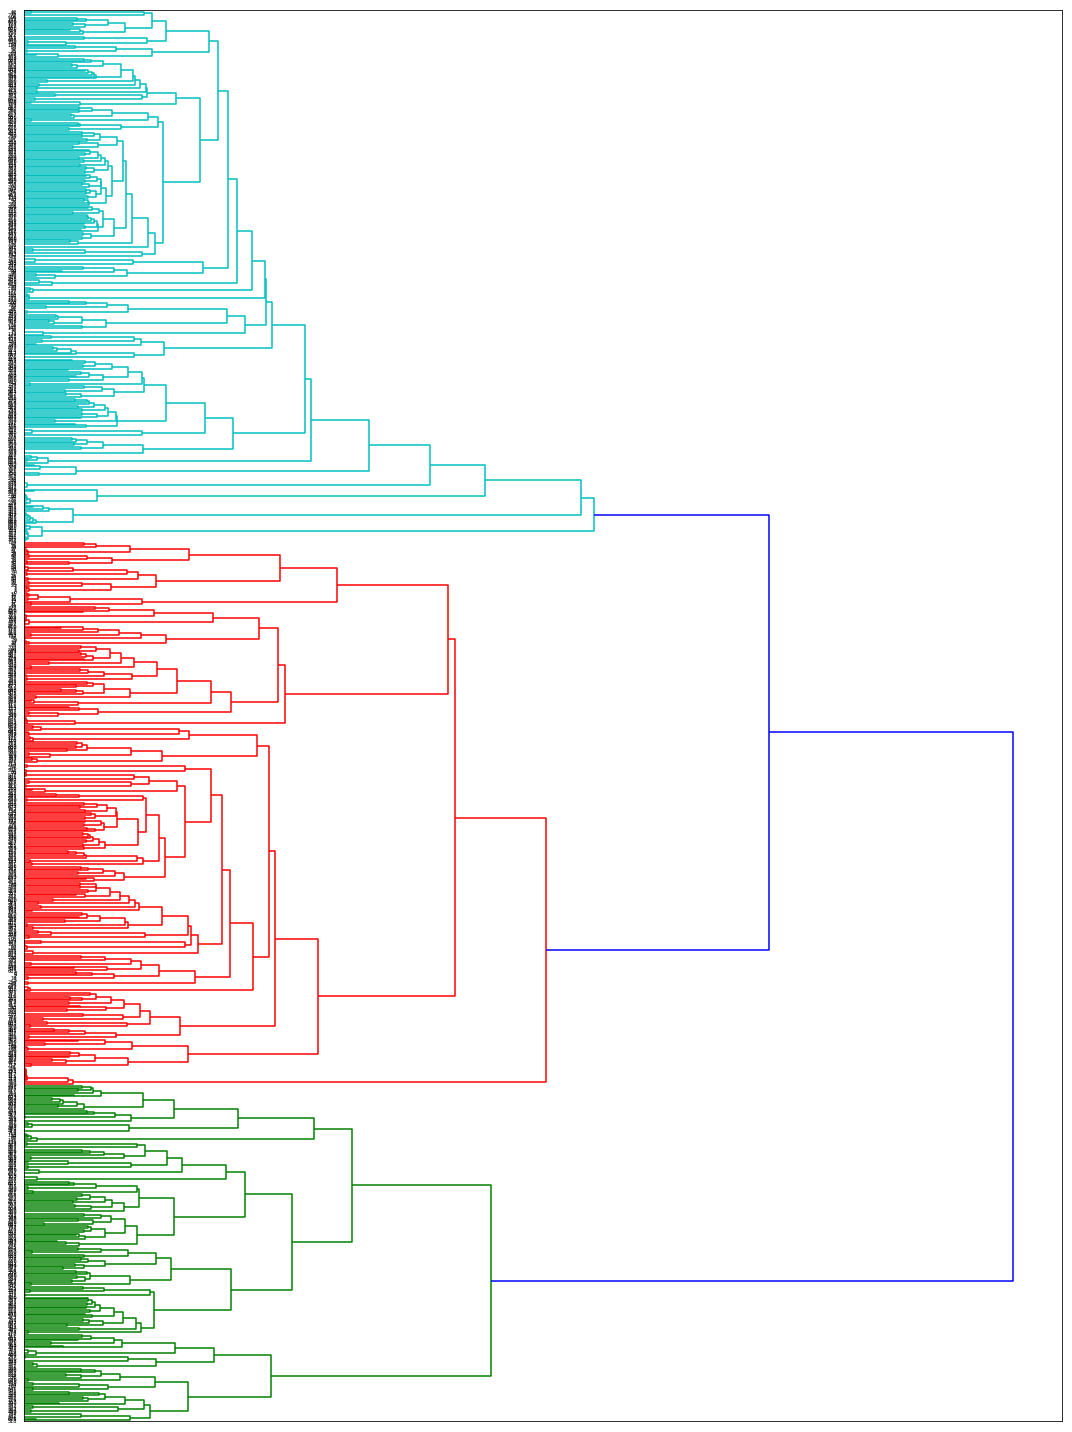

In [63]:
plot_dendogram('middle_east')

The middle east is divided into 3 classes.

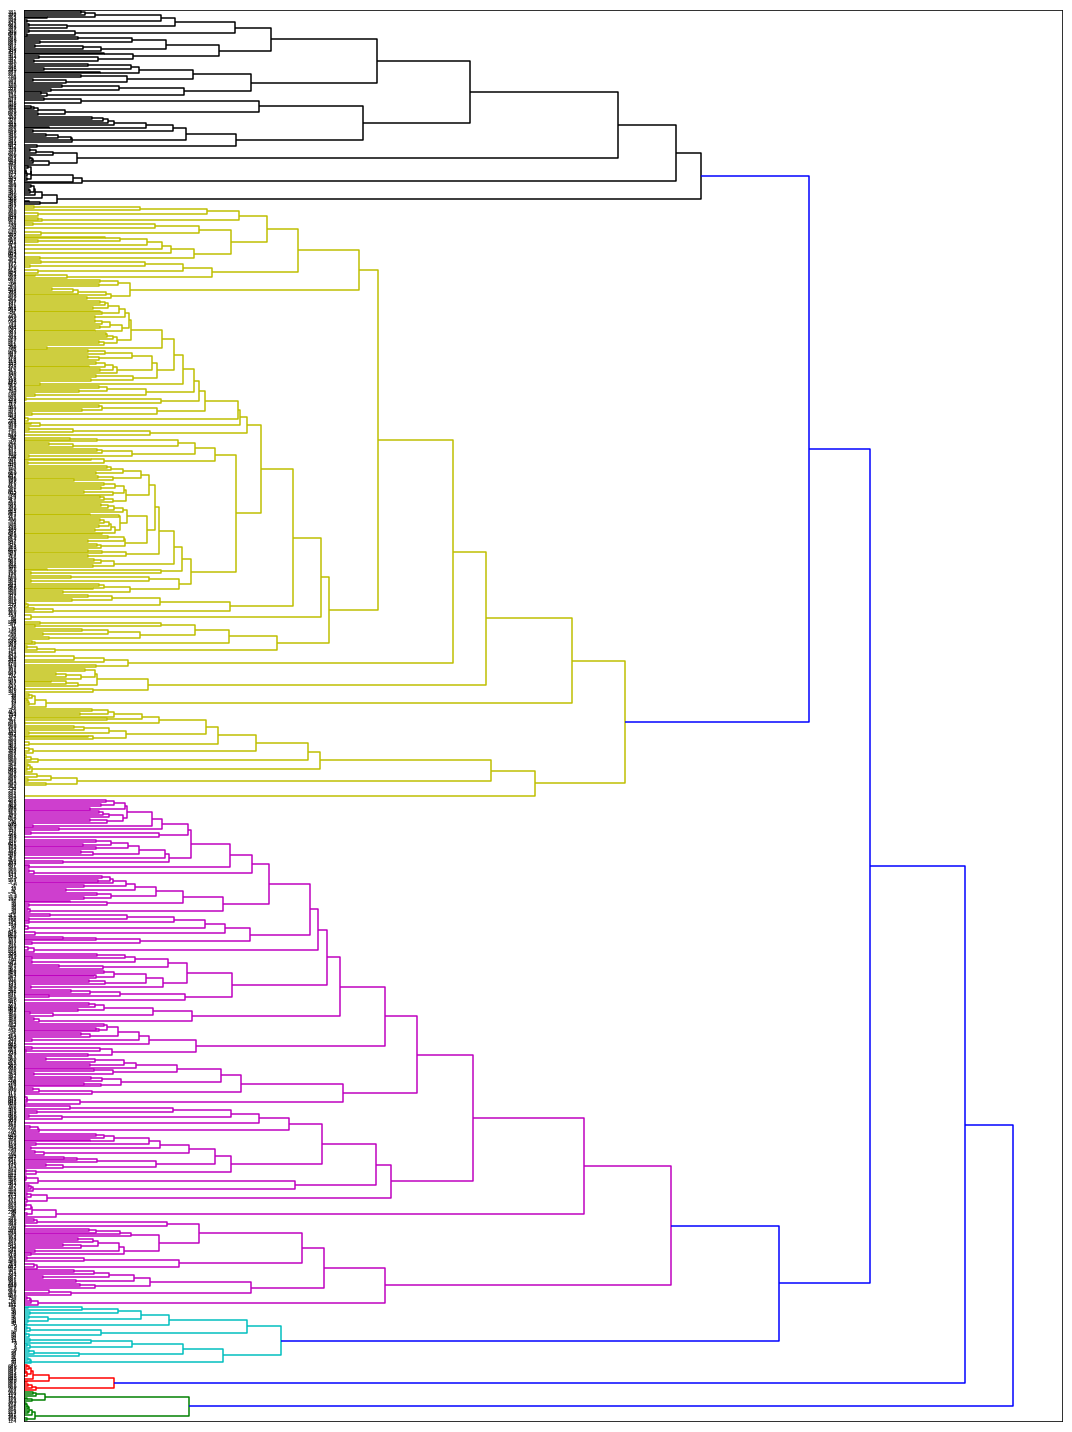

In [64]:
plot_dendogram('europe')

This diagram suggests Europe is not dominated by one or two topics in particular. We can explain that by the fact that Europe is interfering with many countries and organizations (EU, Libya, NATO, Iran, ...)

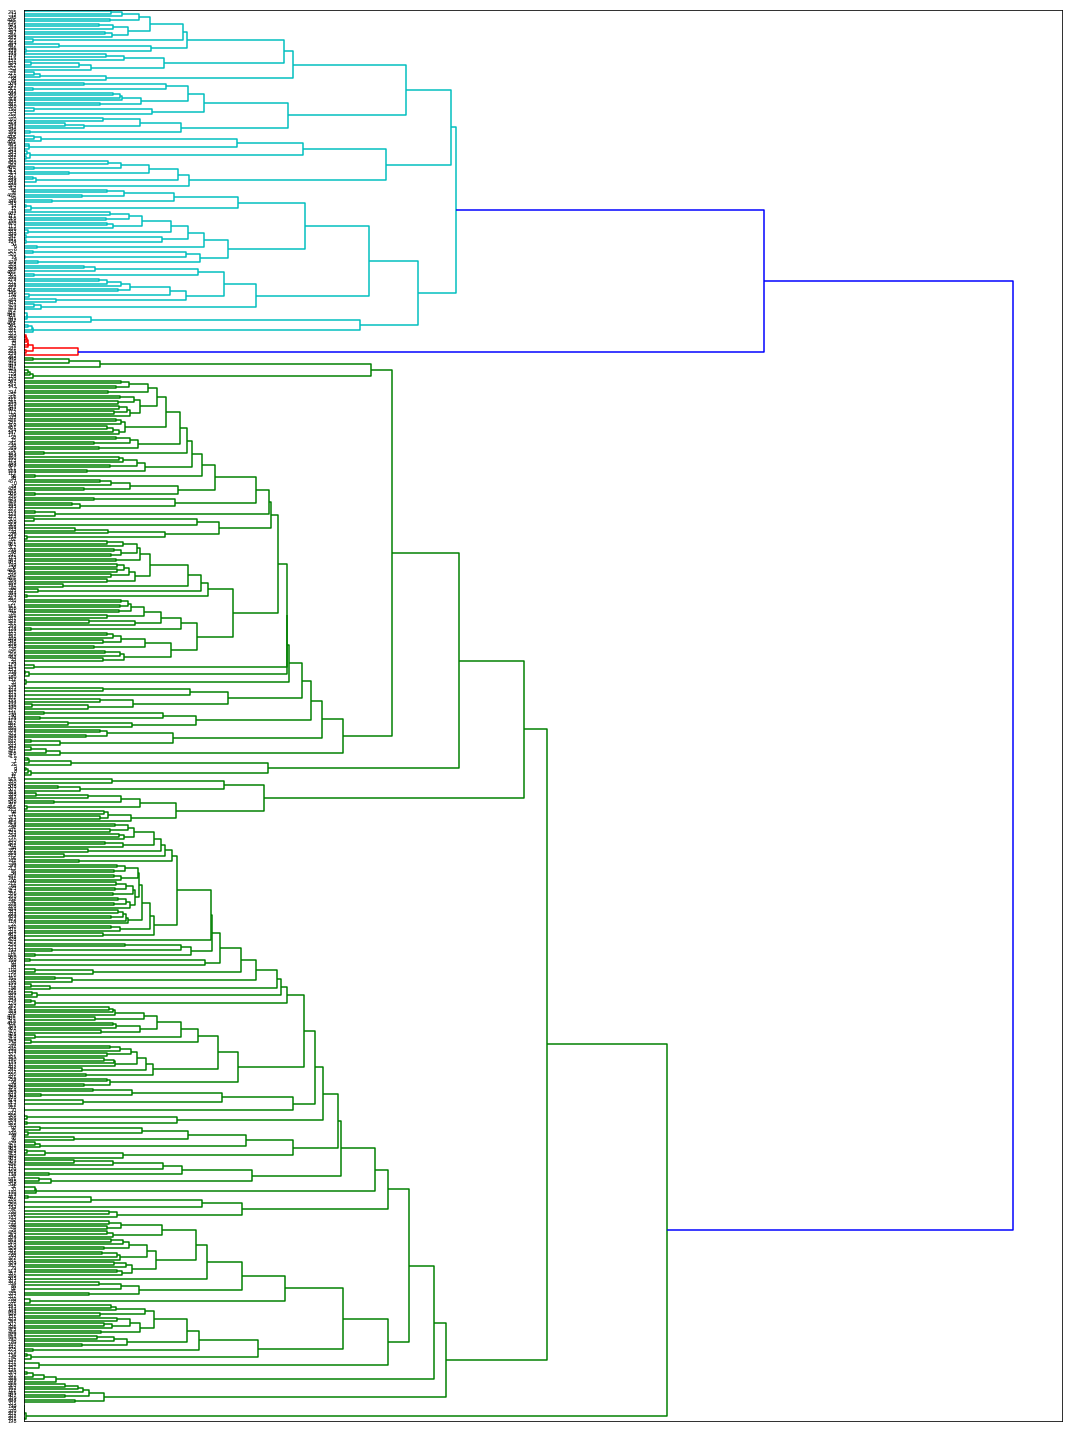

In [65]:
plot_dendogram('central_asia')

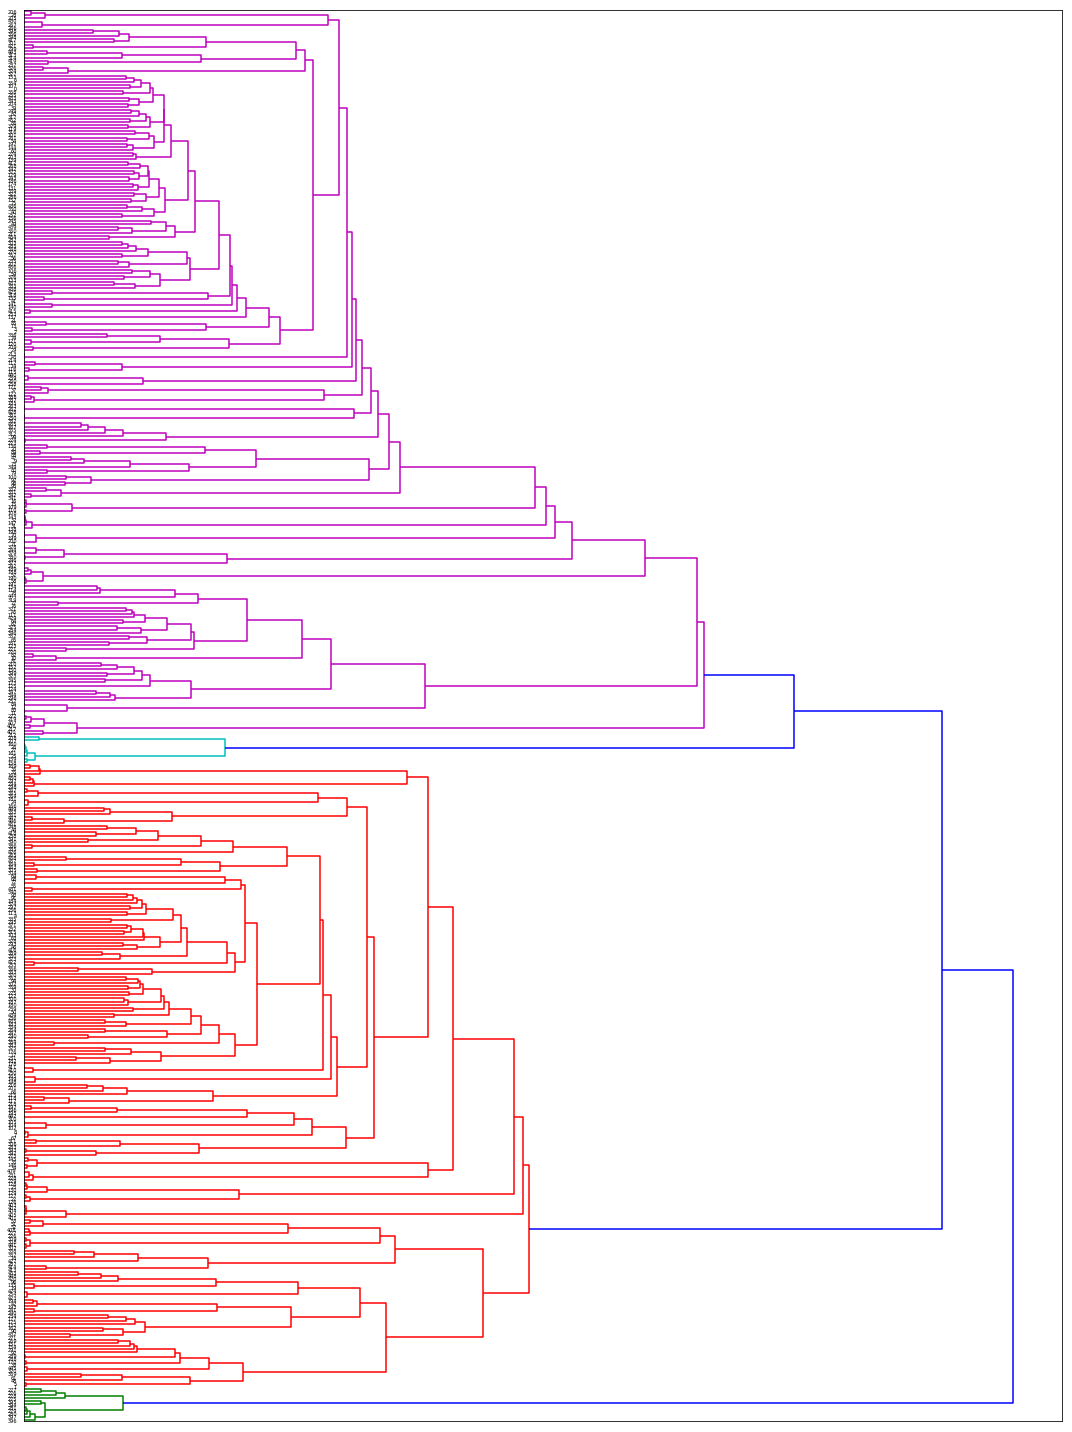

In [66]:
plot_dendogram('far_east')

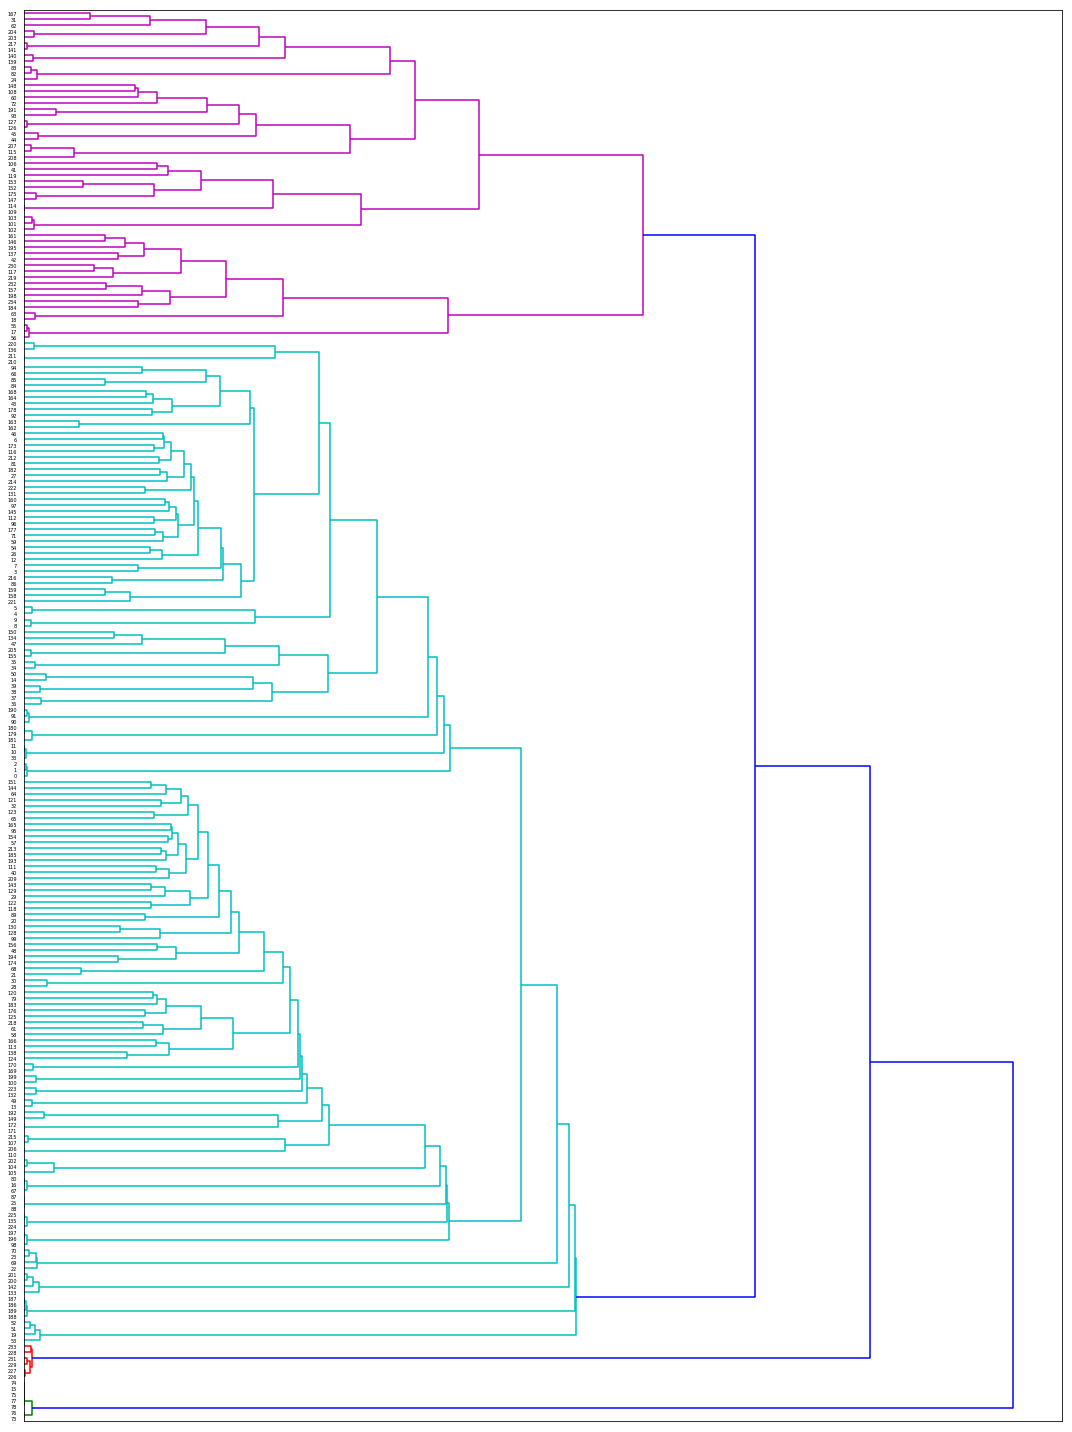

In [79]:
plot_dendogram('russia')

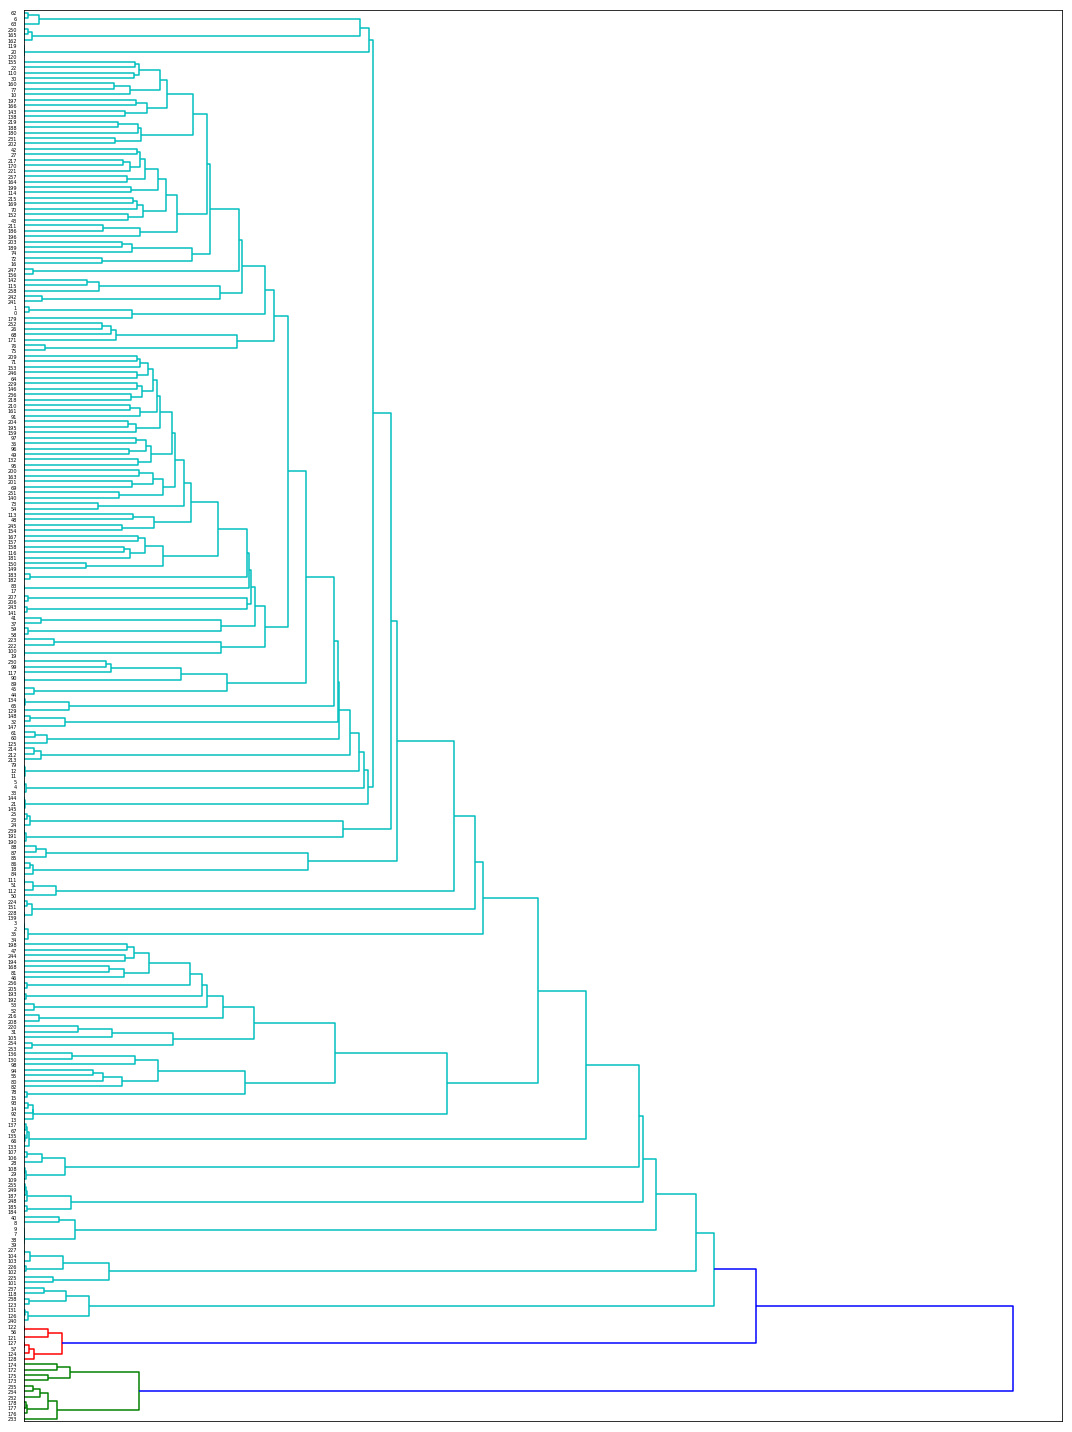

In [80]:
plot_dendogram('latino')

## Word Cloud

In [70]:
# TODO: Thang mets ton code là.
from wordcloud import WordCloud

In [71]:
def wordcloud_visualization(region):
    emails_filtered = emails[emails.content.map(lambda content: Extractor.earth_area(str(content), region))].content
    wordcloud = WordCloud(background_color="white").generate(str(emails_filtered))
    fig, ax = plt.subplots(figsize=(15, 20))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


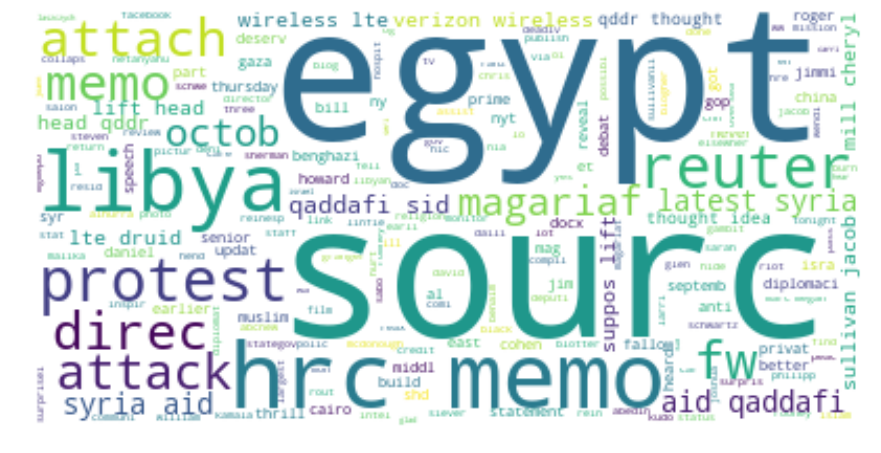

In [72]:
wordcloud_visualization('africa')

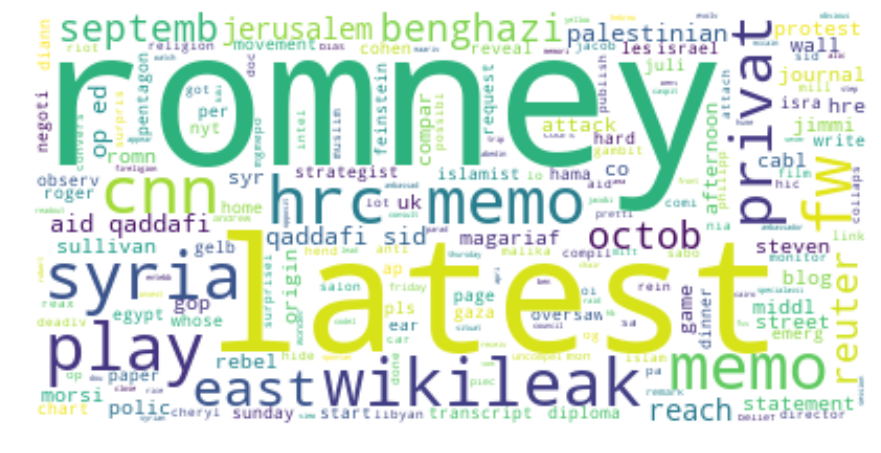

In [73]:
wordcloud_visualization('middle_east')

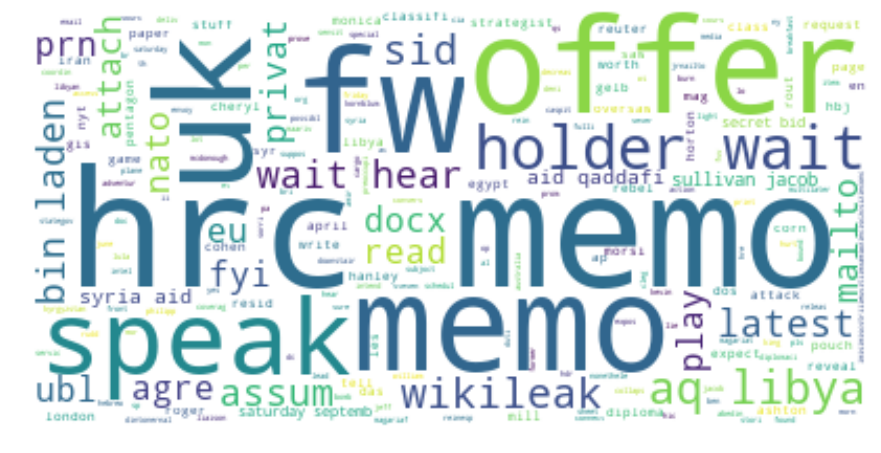

In [74]:
wordcloud_visualization('europe')

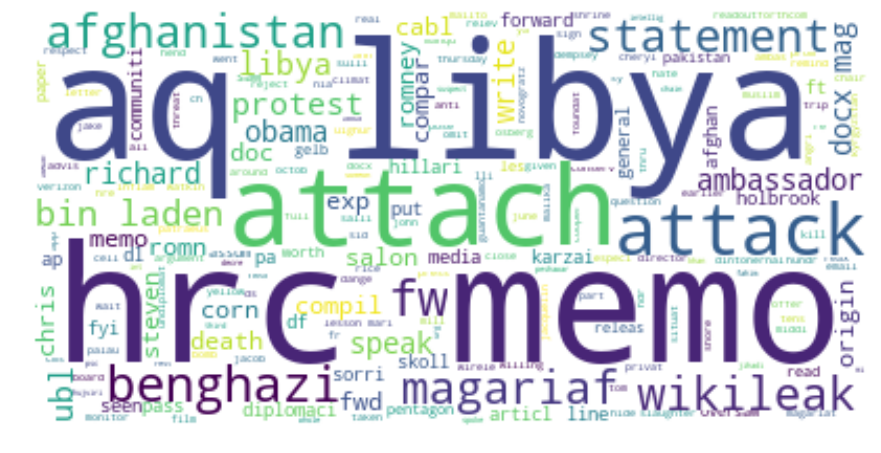

In [75]:
wordcloud_visualization('central_asia')

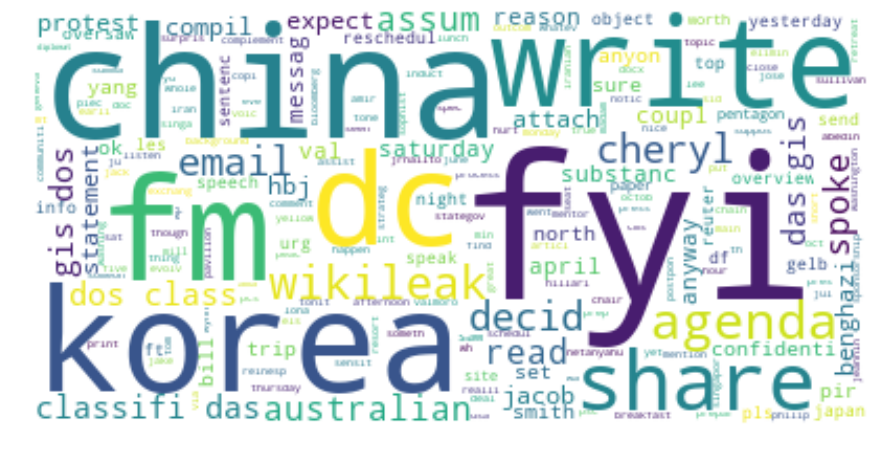

In [76]:
wordcloud_visualization('far_east')

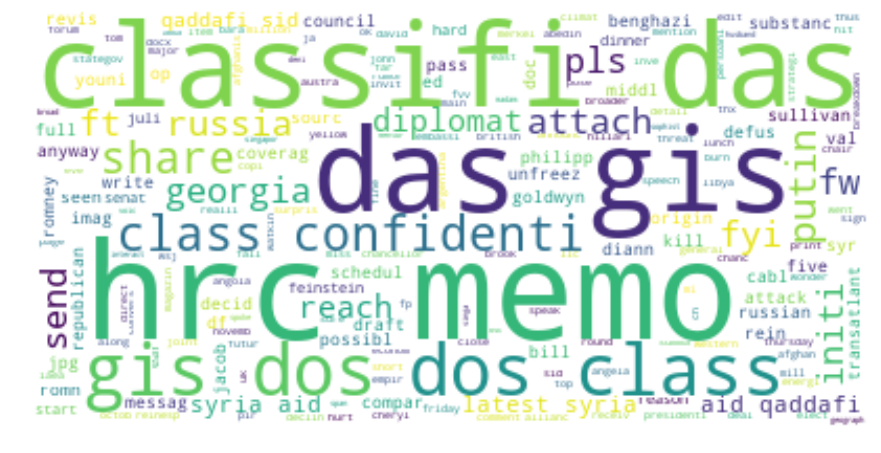

In [77]:
wordcloud_visualization('russia')

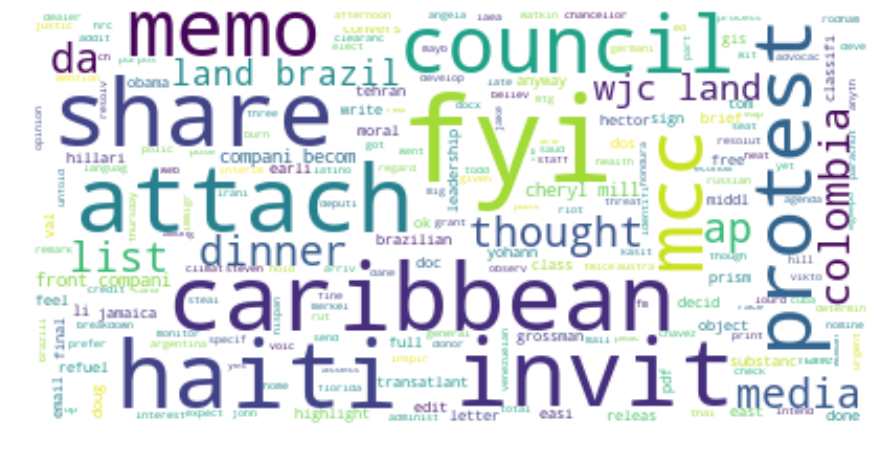

In [78]:
wordcloud_visualization('latino')

## N-gram

In [ ]:
def most_common_word(contents, n=30):
    '''Extraction the most common words from each region'''
    contents_as_str = contents.str.cat(sep=' ')
    contents_as_str = contents_as_str.replace('|', ' ')
    word_freq_dist = nltk.FreqDist(contents_as_str.split())
    most_common = word_freq_dist.most_common(n)
    return most_common

In [180]:
# TODO: Brice mets ton code là.
content = emails_africa.content
content_as_str =  content.str.cat(sep=' ')
content_as_str = content_as_str.replace('|', ' ')

In [210]:
word_tokenize(content_as_str.split())

TypeError: expected string or bytes-like object

In [206]:
def get_ngrams(content,n):
    content_as_str =  content.str.cat(sep=' ')
    content_as_str = content_as_str.replace('|', ' ')
    text = content_as_str
    n_grams = ngrams(word_tokenize(text), n)
    return [ ' '.join(grams) for grams in n_grams]

In [212]:
type(emails_africa.content)

pandas.core.series.Series

In [211]:
get_ngrams(content,2)

TypeError: 'list' object is not callable

In [140]:
def ngrams_bar_plot(content, n, region, m = 30):
    ngrams = get_ngrams(content,n)
    ngramsfreq = collections.Counter(ngrams)
    word_bar_plot(ngramsfreq.most_common(m), region)

In [169]:
ngrams_bar_plot(emails_africa.content, 2, 'Africa')

TypeError: expected string or bytes-like object

# 3. Pre-results

    3.1. Adjacency matrix (Hillary's network) construction

# Network Analysis

In [ ]:
# TODO in milestone 3